# 0.01 Ca2+ Glu application fit

First things first, compile your model file (.mod) so that it can be used by NEURON. This line needs to be run anytime you use a new MOD file for a simulation, or anytime you make changes directly to the text in the MOD file. If you do not recompile a MOD file after editing, your changes will not be noted by NEURON - NEURON will just use the version it knows, i.e., the old version that has been compiled.

In [1]:
#Compile MOD files. !nrnivmodl is a python command and PlaneMods is the subfolder 
# (located in the same folder as the notebook) containing the MOD files. The ! calls the script "nrnivmodl" and runs it. 
# Again, you don't need to run this unless it's the first time that this version of the MOD file is used.
!nrnivmodl PlaneMods

/usr/bin/xcrun
/Users/ElizabethN/Downloads/CDB_Fitting/001uM
-n Mod files:
-n  "PlaneMods/CaPlaneNMDARwMem_EN1.mod"


COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/Users/ElizabethN/opt/anaconda3/lib/python3.8/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.1.0/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.dylib
g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -fPIC  -I /Users/ElizabethN/opt/anaconda3/lib/python3.8/site-packages/neuron/.data/include -o ./libnrnmech.dylib -Wl,-install_name,@rpath/libnrnmech.dylib \
	  ./mod_func.o ./CaPlaneNMDARwMem_EN1.o  -L/Users/ElizabethN/opt/anaconda3/lib/python3.8/site-packages/neuron/.data/lib -lnrniv -Wl,-rpath,/Users/ElizabethN/opt/anaconda3/lib/python3.8/site-packages/neuron/.data/lib    -lreadline
rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.dylib ./.libs/libnrnmech.so
Successfully created x86_64/spe

# Import your python packages and give them easy to call names. Also load some NEURON functions now so you don't have to later. 
We are basically loading only the python packages and parts of the NEURON program that we need, which saves us memory and allows things to run faster without losing any functionality. This is one of the advantages python has over matlab.

In [1]:
import neuron # self-explanatory
from neuron import h, gui # NEURON libraries containing funtions that we will use 
import numpy as np # python library for math functions
import pandas as pd # python library for working with dataframes, i.e. spreadsheets/tables
import matplotlib.pyplot as plt # python library for plotting

# Load external files & initialize.
h.load_file("stdrun.hoc");
h.stdinit();
h.load_file("mulfit.hoc", "MulRunFitter")
h.load_file("stdgui.hoc")

1.0

Load and visualize experimental data to be fit. Data is an averaged trace that has been decimated (factor of 10) to improve speed of fitting. The averaged trace was made using another notebook ("avtrace1") that I've provided. The time component and current component are saved as separate numpy arrays, then loaded into memory here as variables.

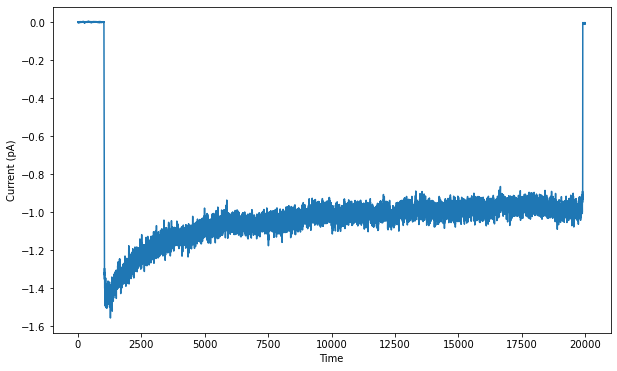

Length: 39815


In [2]:
# Experimental Data
# Load the time array in seconds, convert to ms
timedec = np.load("time_Ca001GluApp.npy")
expt = timedec * 1000

# Load current array
expi = np.load("Ca001GluApp.npy")

# Visualize the loaded experimental data
plt.figure(figsize=(10, 6))
plt.plot(expt, expi)
plt.xlabel('Time')
plt.ylabel('Current (pA)')
#plt.xlim(18000, 19750)
#plt.ylim(-1.2, -0.8)
plt.show()
# Print the length of the concatenated trace
print("Length:", len(expi))

In [3]:
#Finding Ipeak over a 30 ms range

Ipeak_min, Ipeak_max = 1060, 1090

indices = (expt >= Ipeak_min) & (expt <= Ipeak_max)
filtered_y = expi[indices]

mean_y = np.mean(filtered_y)

print(f"Mean y-value between x = {Ipeak_min} and x = {Ipeak_max}: {mean_y}")

Mean y-value between x = 1060 and x = 1090: -1.452693962689468


In [4]:
#Finding Iss over a 1 s range

Iss_min, Iss_max = 18750, 19750

indices = (expt >= Iss_min) & (expt <= Iss_max)
filtered_y = expi[indices]

mean_y = np.mean(filtered_y)

print(f"Mean y-value between x = {Iss_min} and x = {Iss_max}: {mean_y}")

Mean y-value between x = 18750 and x = 19750: -0.9897650303818373


# Build the model. 
First, we create a cell and define some properties of the cell. The properties don't matter too much for our purposes. 
The cell is a simple ball model.

In [5]:
soma = h.Section(name='soma')

In [6]:
# properties of cell
soma.L = 50
soma.diam = 50
soma.Ra = 10 #ohm*cm
soma.cm = 1 #μF/cm^2

Next, we add our channels to the cell. "CaPlaneNMDARwMem" is the name of our previously compiled MOD file.
Note - NEURON will not recognize the "mechanism" if the name given here is not the same as the name in the "POINT_PROCESS CaPlaneNMDARwMem" line in the MOD file.

In [7]:
# insert NMDARs
NMDAR = h.CaPlaneNMDARwMem(soma(0.5))

In [8]:
# dir(soma) # can show you that the channels have been added

Designate the variables you want to monitor for the simulation as "vectors", which is what NEURON calls arrays. These variables are either global (time) or specific to the object you specify. Available variables can be found in the MOD file or in the soma directory as shown above. You don't need to set up all of these variables - you only need time and current. However, it can be nice to be able to visually check your stimuli. A good check that everything is working properly on the simulation end is to monitor whether the voltage at the soma object (soma(0.5)._ref_v) is the same as the voltage reported by your channel object (NMDAR._ref_Vm). 

In [9]:
#Set up recording vectors for simulation variables
time = h.Vector()
time.record(h._ref_t)

#Set up recording vectors for section variables
vm = h.Vector()
vm.record(soma(0.5)._ref_v)

#Set up recording vectors for mechanism variables
vsyn = h.Vector()
vsyn.record(NMDAR._ref_Vm)

im = h.Vector()
im.record(NMDAR._ref_Inmda)

A = h.Vector() # agonist
A.record(NMDAR._ref_A)

# M = h.Vector() # not needed for this simulation, since we aren't using memantine
# M.record(NMDAR._ref_M)

fs = 2   # sampling frequency in kHz

# Create your stimulus
We need a method for applying agonist and antagonist to our cell. Here we model an increase in agonist/antagonist concentration using a logistic function.

In [10]:
# Define function used for building vectors to play into NEURON
def logistic(x, xhalf, k, min, max):
    """
    Returns a logistic curve y(x), with a midpoint of xhalf, and a slope of k
    y(x) = (max - min) / (1 + e^(-k(x - xhalf))) + min
    
    Parameters:
    -----------
    x: sequence array
        The x index array for time of which the curve should occur
    xhalf: int, float
        The value in terms of x that signifies the midpoint of x
    k: int, float
        The steepness or rate of increase of the sigmoid function
    min: int, float
        Minimum asymptote of the logistic function
    max: int, float
        Maximum asymptote of the logistic function

    Returns:
    --------
    y: array
        The y-values of len(x) of the logistic function
    """
    y = min + (max - min) / (1 + np.exp(-k * (x - xhalf)))
    return y

# Example parameters
x0 = 120 # Midpoint of the logistic function
fs = 2  # Sampling frequency in Hz
rise_time_10_90 = 150  # 10-90% rise time in ms

# Calculate the slope (k) for the logistic function
k = np.log(9) / (rise_time_10_90/2)

Create arrays that match your barrel protocol. The arrays are created from three parts, termed slices. Then plot your stimulus to check it.

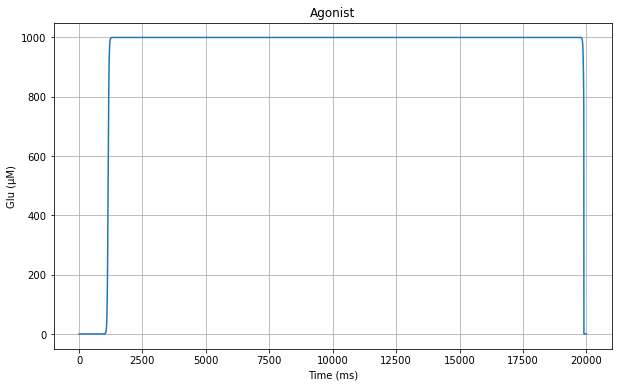

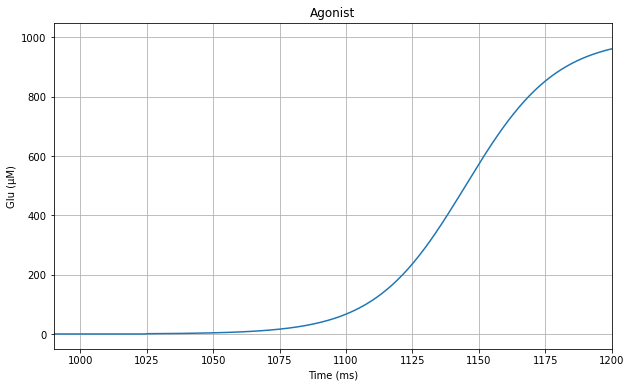

In [11]:
# create array for protocol and define [agonist]
Glu = np.zeros(20000*fs)
gconc = 1000

# First slice defines the increase in [agonist]
GluOnx = np.arange(0, 1000*fs)
GluOny = logistic(GluOnx, x0 * fs, k, min=0, max=gconc)
Glu[1025*fs:2025*fs] = GluOny

# Second slice defines steady state [agonist]
Glu[2025*fs:19800*fs] = gconc

# Third slice defines decrease in [agonist]
GluOffx = np.arange(0, 100*fs)
GluOffy = logistic(GluOffx, x0 * fs, -k, min=0, max=gconc)
Glu[19800*fs:19900*fs] = GluOffy


# Plot
timestep = 1 / fs  # Time step between samples
agtime = np.arange(len(Glu)) * timestep

plt.figure(figsize=(10, 6))
plt.plot(agtime, Glu)
plt.xlabel("Time (ms)")
plt.ylabel("Glu (μM)")  # Modify the units accordingly
plt.title("Agonist")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(agtime, Glu)
plt.xlabel("Time (ms)")
plt.ylabel("Glu (μM)")  # Modify the units accordingly
plt.title("Agonist")
plt.xlim(990, 1200)
plt.grid(True)
plt.show()

Now we "play" the arrays into NEURON vectors (think play as in playing a movie"). I don't like the terminology but that's what they chose.

In [12]:
# Create vector from array and play into the mechanism
GluProtocol = h.Vector(Glu)
GluProtocol.play(NMDAR._ref_A, 0.5)

Vector[8]

# Set your simulation parameters, run the simulation, and plot the results

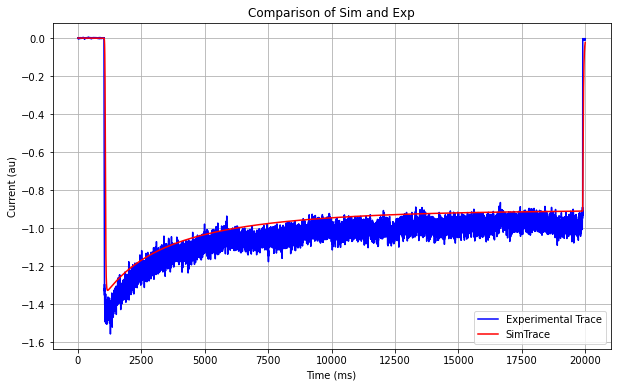

In [13]:
# simulation parameters
h.tstop = 20000 # ms, simulation duration
h.steps_per_ms = 2
h.dt = 0.5
h.celsius = 23

# You can quickly modify your model parameters (rate constants, N, [Ca], etc.) as shown below. Helpful for quickly testing different parameter values 
# without modifying the original MOD FILE, and for hand-fitting your initial simulation.

NMDAR.Ca = 0.01

NMDAR.kCa1 = 100000
NMDAR.kCa0 = 8200
NMDAR.ka1 = .005
NMDAR.ka0 = .025
NMDAR.kg1 =.071
NMDAR.kg0 = .305
NMDAR.kcdd1 = .0007662
NMDAR.kcdd0 = .0006476
NMDAR.kd1 = 0.000079496
NMDAR.kd0 = 0.00016831
NMDAR.k1M = 0
NMDAR.k0M = 0
NMDAR.ka1M = 0
NMDAR.ka0M = 0
NMDAR.kg1M = 0
NMDAR.kg0M = 0
NMDAR.kcdd1M = 0
NMDAR.kcdd0M = 0
NMDAR.kd1M = 0
NMDAR.kd0M = 0
NMDAR.nrecepts = 2.211


# Run the NEURON simulation
h.run()


# plt.figure(figsize=(10, 6))
# plt.plot(time, im)
# plt.xlabel("Time (ms)")
# plt.ylabel("Current (pA)")  # Modify the units accordingly
# plt.title("SimTrace")
# plt.grid(True)
# plt.show()

# # Can plot the experimental data too, just for a visual comparison
# plt.figure(figsize=(10, 6))
# plt.plot(expt, expi)
# plt.xlabel('Time')
# plt.ylabel('Current (pA)')
# plt.title("Experimental Trace")
# plt.grid(True)
# plt.show()

# Plot together if you want a better visual comparision
plt.figure(figsize=(10, 6))
# Plot the first dataset in black
plt.plot(expt, expi, color='blue', label='Experimental Trace')
# Plot the second dataset in blue
plt.plot(time, im, color='red', label='SimTrace')
plt.xlabel('Time (ms)')
plt.ylabel('Current (au)')  # Ensure units are consistent for both datasets
plt.title("Comparison of Sim and Exp")
#plt.xlim(1020,1065)
plt.grid(True)
plt.legend()
plt.show()

# The below step is not necessary for fitting, 
but generally makes doing array manipulations for plotting easier. Can skip if you want. All it does is add or remove values to/from the end baseline region of the experimental trace to ensure it is the exact same number of points as the simulation trace.

In [14]:
# Convert simulation values to arrays and check that lengths of sim and exp data match
simt = np.array(time)
simi = np.array(im)

print("simi:", len(simi))
print("expi", len(expi))

simi: 40001
expi 39815


In [15]:
# Make the lengths match if they don't
# For expt, add the next three sequential time steps
time_step = expt[-1] - expt[-2]

while len(expt) < len(simt):
    expt = np.append(expt, expt[-1] + time_step)
    
print("expt:", len(expt))
print(expt[-5:]) #check that we added the appropriate values

# For expi, just add the final value (i.e. a baseline value) 
while len(expi) < len(simi):
    expi = np.append(expi, expi[-1])
    
print("expi:", len(expi))
print(expi[-5:]) #check that we added the appropriate values

expt: 40001
[20090.41659104 20090.91890168 20091.42121233 20091.92352297
 20092.42583362]
expi: 40001
[-0.00706253 -0.00706253 -0.00706253 -0.00706253 -0.00706253]


# Time to fit! 

First we create a Multiple Run Fitter (mrf), neuron's built-in fitting tool. We then create a generator within the mrf (think of the mrf as a folder, and a generator as a subfolder) then fill the generator with experimental data and the simulation data before setting up our fit.

In [16]:
# Create NEURON Vectors and fill with experimental data, for later fitting.
expt_vec = h.Vector(expt)
expi_vec = h.Vector(expi)

In [17]:
# Create a Multiple Run Fitter
mrf = h.MulRunFitter()
mrf.p.pf.title = "CaPlanesFit001_GluApp"
mrf.p.mulfit.title = "CaPlanesFit001_GluApp"

In [18]:
# Add generator
mrf.p.addgen(0)
gen0 = mrf.p.pf.generatorlist.object(0)
mrf.p.usepanel()

0.0

In [19]:
# Turn on generator
gen0.toggle()

0.0

Set up your fitness measure, i.e. the method with which the simulation will be fit to data. We are using principal axis reduction.

In [20]:
# Add a fitness measure
fitness_measure = h.RegionFitness()

# Specify the variable from the simulation for fitting
gen0.gen.add('CaPlaneNMDARwMem[0].Inmda', fitness_measure)

# Set the data to be fit to
fitness_measure.set_data(expt_vec, expi_vec) #defined earlier, but loaded here

0.0

Display and test your generator, i.e. the object that contains your simulation and experimental data.

In [21]:
# Display generator so you can watch your fit progress.
mrf.p.gmode = 1
mrf.p.gmodestr = "Display"
mrf.p.gensel(0, 1)

0.0

Fitness Error Value: 0.009404158599945643


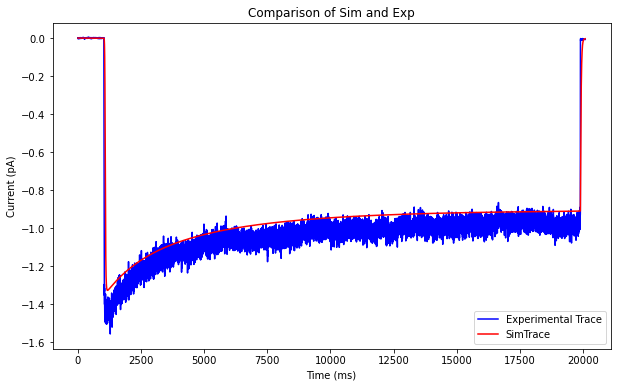

In [22]:
# Test the run fitness generator
error_value_init = gen0.gen.efun() 

# Print the error value
print("Fitness Error Value:", error_value_init)

plt.figure(figsize=(10, 6))
plt.plot(expt, expi, color='blue', label='Experimental Trace')
plt.plot(time, im, color='red', label='SimTrace')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')  # Ensure units are consistent for both datasets
plt.title("Comparison of Sim and Exp")
plt.grid(False)
plt.legend()
plt.show()

# Manage the parameters for your simulation/fit
The following cells designate your parameters, set their initial values, and allow you to choose which are fixed or free:

In [23]:
# Append parameters with kCa0
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kCa1"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kCa0"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka1"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka0"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg1"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg0"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd1"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd0"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd1"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd0"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].k1M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].k0M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka1M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka0M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg1M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg0M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd1M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd0M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd1M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd0M"))
mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].nrecepts"))

21.0

In [24]:
# # Append parameters NO kCa0
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kCa1"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka1"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka0"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg1"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg0"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd1"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd0"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd1"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd0"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].k1M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].k0M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka1M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].ka0M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg1M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kg0M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd1M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kcdd0M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd1M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].kd0M"))
# mrf.p.pf.parmlist.append(h.RunFitParm("CaPlaneNMDARwMem[0].nrecepts"))

In [25]:
# Set parameter values with kCa0
# : Transition b/t planes
#     kCa1 = 1e-3         (uM-1 s-1)    :Ca "binding"
mrf.p.pf.parmlist.object(0).val = 100000
#     kCa0 = 0.75e-3      (ms-1)        :Ca "unbinding"
mrf.p.pf.parmlist.object(1).val = 8200

# :Unblocked Arm
#     ka1 = 31.6           (uM-1 s-1)   :Agonist binding
mrf.p.pf.parmlist.object(2).val = .005
#     ka0 = 1010e-3        (ms-1)       :Agonist unbinding
mrf.p.pf.parmlist.object(3).val = 0.025


# :  Gating 
#     kg1 = 4772.41e-3     (ms-1)       :opening
mrf.p.pf.parmlist.object(4).val = 0.071
#     kg0 = 557e-3         (ms-1)       :closing
mrf.p.pf.parmlist.object(5).val = 0.305

# :  Desensitization
#     kcdd1 = 32.12e-3     (ms-1)       :into Ca-dependent desen
mrf.p.pf.parmlist.object(6).val = .0007662

#     kcdd0 = 2.92e-3      (ms-1)       :out of CDD
mrf.p.pf.parmlist.object(7).val = .0006476
#     kd1 = 0.66e-3        (ms-1)       :into desens
mrf.p.pf.parmlist.object(8).val = 0.000079496
#     kd0 = 0.05e-3        (ms-1)       :out of desens
mrf.p.pf.parmlist.object(9).val = 0.00016831


# :Blocked Arm
#     k1M = 30              (uM-1 s-1)  :Block rate
mrf.p.pf.parmlist.object(10).val = 0
#     k0M = 24e-3           (ms-1)      :Unblock rate
mrf.p.pf.parmlist.object(11).val = 0
#     ka1M = 31.6           (uM-1 s-1)  :Agonist binding
mrf.p.pf.parmlist.object(12).val = 0
#     ka0M = 1010e-3        (ms-1)      :Agonist unbinding
mrf.p.pf.parmlist.object(13).val = 0

# :  Gating                                                
#     kg1M = 4772.41e-3     (ms-1)      :opening
mrf.p.pf.parmlist.object(14).val = 0
#     kg0M = 53.017e-3      (ms-1)      :closing 
mrf.p.pf.parmlist.object(15).val = 0

# :  Desensitization
#     kcdd1M = 64.24e-3     (ms-1)      :into Ca-dependent desen
mrf.p.pf.parmlist.object(16).val = 0
#     kcdd0M = 0.6e-3       (ms-1)      :out of CDD
mrf.p.pf.parmlist.object(17).val = 0
#     kd1M = 0.54e-3        (ms-1)      :into desens
mrf.p.pf.parmlist.object(18).val = 0
#     kd0M = 0.0125e-3      (ms-1)      :out of desens
mrf.p.pf.parmlist.object(19).val = 0

# :  Other params
#     nrecepts = 0.5     arbitrary due to normalization (I/I)     
mrf.p.pf.parmlist.object(20).val = 2.211

In [26]:
# # NO kCa0
# # Set parameter values
# # : Transition b/t planes
# #     kCa1 = 1e-3         (uM-1 s-1)    :Ca "binding"
# mrf.p.pf.parmlist.object(0).val = 8.4
# #     kCa0 = 0.75e-3      (ms-1)        :Ca "unbinding"
# #mrf.p.pf.parmlist.object(1).val = mrf.p.pf.parmlist.object(0).val * 0.001146

# # :Unblocked Arm
# #     ka1 = 31.6           (uM-1 s-1)   :Agonist binding
# mrf.p.pf.parmlist.object(1).val = .005
# #     ka0 = 1010e-3        (ms-1)       :Agonist unbinding
# mrf.p.pf.parmlist.object(2).val = 0.025


# # :  Gating 
# #     kg1 = 4772.41e-3     (ms-1)       :opening
# mrf.p.pf.parmlist.object(3).val = 0.071
# #     kg0 = 557e-3         (ms-1)       :closing
# mrf.p.pf.parmlist.object(4).val = 0.305

# # :  Desensitization
# #     kcdd1 = 32.12e-3     (ms-1)       :into Ca-dependent desen
# mrf.p.pf.parmlist.object(5).val = .03553

# #     kcdd0 = 2.92e-3      (ms-1)       :out of CDD
# mrf.p.pf.parmlist.object(6).val = 0.00101
# #     kd1 = 0.66e-3        (ms-1)       :into desens
# mrf.p.pf.parmlist.object(7).val = 0.00006
# #     kd0 = 0.05e-3        (ms-1)       :out of desens
# mrf.p.pf.parmlist.object(8).val = 0.00014


# # :Blocked Arm
# #     k1M = 30              (uM-1 s-1)  :Block rate
# mrf.p.pf.parmlist.object(9).val = 0
# #     k0M = 24e-3           (ms-1)      :Unblock rate
# mrf.p.pf.parmlist.object(10).val = 0.78803155
# #     ka1M = 31.6           (uM-1 s-1)  :Agonist binding
# mrf.p.pf.parmlist.object(11).val = .005
# #     ka0M = 1010e-3        (ms-1)      :Agonist unbinding
# mrf.p.pf.parmlist.object(12).val = 0.025

# # :  Gating                                                
# #     kg1M = 4772.41e-3     (ms-1)      :opening
# mrf.p.pf.parmlist.object(13).val = 0.071
# #     kg0M = 53.017e-3      (ms-1)      :closing 
# mrf.p.pf.parmlist.object(14).val = 0.000724664

# # :  Desensitization
# #     kcdd1M = 64.24e-3     (ms-1)      :into Ca-dependent desen
# mrf.p.pf.parmlist.object(15).val = 64.24e-3
# #     kcdd0M = 0.6e-3       (ms-1)      :out of CDD
# mrf.p.pf.parmlist.object(16).val = 0.6e-3
# #     kd1M = 0.54e-3        (ms-1)      :into desens
# mrf.p.pf.parmlist.object(17).val = 0.011572
# #     kd0M = 0.0125e-3      (ms-1)      :out of desens
# mrf.p.pf.parmlist.object(18).val = 0.000109522

# # :  Other params
# nrecepts = 0.5     #arbitrary due to normalization (I/I)     
# mrf.p.pf.parmlist.object(19).val = 2.377877931

In [27]:
# #Shows that params have been added to parmlist.

# print(mrf.p.pf.parmlist.o(0).name, mrf.p.pf.parmlist.o(0).val) 
# print(mrf.p.pf.parmlist.o(19).name, mrf.p.pf.parmlist.o(19).val)


In [28]:
# Display parameter panel in NEURON, makes it easier to follow if you can just see it
mrf.p.showargs()

0.0

In [29]:
# Toggle variables. 0 = fixed, 1 = free. With kCa0

# kCa1
mrf.p.pf.parmlist.o(0).doarg = 0
# kCa0
mrf.p.pf.parmlist.o(1).doarg = 0
# ka1
mrf.p.pf.parmlist.o(2).doarg = 0
# ka0 
mrf.p.pf.parmlist.o(3).doarg = 0
# kg1 
mrf.p.pf.parmlist.o(4).doarg = 0
# kg0 
mrf.p.pf.parmlist.o(5).doarg = 0
# kcdd1
mrf.p.pf.parmlist.o(6).doarg = 0
# kcdd0 
mrf.p.pf.parmlist.o(7).doarg = 0
# kd1 
mrf.p.pf.parmlist.o(8).doarg = 0
# kd0 
mrf.p.pf.parmlist.o(9).doarg = 0
# k1M 
mrf.p.pf.parmlist.o(10).doarg = 0
# k0M 
mrf.p.pf.parmlist.o(11).doarg = 0
# ka1M 
mrf.p.pf.parmlist.o(12).doarg = 0
# ka0M 
mrf.p.pf.parmlist.o(13).doarg = 0
# kg1M 
mrf.p.pf.parmlist.o(14).doarg = 0
# kg0M 
mrf.p.pf.parmlist.o(15).doarg = 0
# kcdd1M
mrf.p.pf.parmlist.o(16).doarg = 0
# kcdd0M 
mrf.p.pf.parmlist.o(17).doarg = 0
# kd1M
mrf.p.pf.parmlist.o(18).doarg = 0
# kd0M 
mrf.p.pf.parmlist.o(19).doarg = 0
# nrecepts
mrf.p.pf.parmlist.o(20).doarg = 1

mrf.p.pf.def_parmlist_use()

0.0

In [30]:
# #NO kCa0

# # Toggle variables. 0 = fixed, 1 = free

# # kCa1
# mrf.p.pf.parmlist.o(0).doarg = 0
# # ka1
# mrf.p.pf.parmlist.o(1).doarg = 0
# # ka0 
# mrf.p.pf.parmlist.o(2).doarg = 0
# # kg1 
# mrf.p.pf.parmlist.o(3).doarg = 0
# # kg0 
# mrf.p.pf.parmlist.o(4).doarg = 0
# # kcdd1
# mrf.p.pf.parmlist.o(5).doarg = 1
# # kcdd0 
# mrf.p.pf.parmlist.o(6).doarg = 1
# # kd1 
# mrf.p.pf.parmlist.o(7).doarg = 0
# # kd0 
# mrf.p.pf.parmlist.o(8).doarg = 0
# # k1M 
# mrf.p.pf.parmlist.o(9).doarg = 0
# # k0M 
# mrf.p.pf.parmlist.o(10).doarg = 0
# # ka1M 
# mrf.p.pf.parmlist.o(11).doarg = 0
# # ka0M 
# mrf.p.pf.parmlist.o(12).doarg = 0
# # kg1M 
# mrf.p.pf.parmlist.o(13).doarg = 0
# # kg0M 
# mrf.p.pf.parmlist.o(14).doarg = 0
# # kcdd1M
# mrf.p.pf.parmlist.o(15).doarg = 0
# # kcdd0M 
# mrf.p.pf.parmlist.o(16).doarg = 0
# # kd1M
# mrf.p.pf.parmlist.o(17).doarg = 0
# # kd0M 
# mrf.p.pf.parmlist.o(18).doarg = 0
# # nrecepts
# mrf.p.pf.parmlist.o(19).doarg = 1

# mrf.p.pf.def_parmlist_use()

In [31]:
# Step 5C: Constrain parameters
mrf.p.showdomain()
mrf.p.uselog(1)
mrf.p.limits(1e-5, 1e5)

0.0

# Manage your optimization settings:

In [32]:
# Choose and use optimizer
mrf.opt.set_optimizer(h.mulfit_optimizers_[0].s)
mrf.p.mulfit.showopt()

# Change "# of quad forms before return"
mrf.opt.optimizer.nstep = 1

# Run the fit

nquad=0 nefun=1 time=0 e=0.0094041586
nquad=1 nefun=6 time=0 e=0.0052636555
nquad=0 nefun=1 time=0 e=0.0052636555
nquad=1 nefun=6 time=0 e=0.005215792 
nquad=0 nefun=1 time=0 e=0.005215792 
nquad=0 nefun=1 time=0 e=0.0052157875
nquad=0 nefun=1 time=0 e=0.0052157875


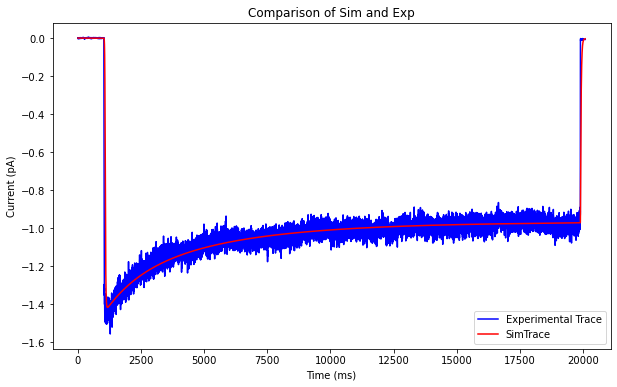

Fitness Error Value: 0.005215787461658865
kD: 12.195121951219512


In [33]:
# Run optimizer
for _ in range(5):
    mrf.prun()

plt.figure(figsize=(10, 6))
plt.plot(expt, expi, color='blue', label='Experimental Trace')
plt.plot(time, im, color='red', label='SimTrace')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')  # Ensure units are consistent for both datasets
plt.title("Comparison of Sim and Exp")
plt.grid(False)
plt.legend()

plt.show()

error_value_final0 = gen0.gen.efun()
# Print the error value
print("Fitness Error Value:", error_value_final0)

kD = (mrf.p.pf.parmlist.object(0).val/mrf.p.pf.parmlist.object(1).val)
# Print the kD value
print("kD:", kD)

If you want to inspect/adjust the figure without waiting for the fit to run again, just uncomment the cell below:

In [34]:
# plt.figure(figsize=(10, 6))
# plt.plot(expt, expi, color='blue', label='Experimental Trace')
# plt.plot(time, im, color='red', label='SimTrace')
# plt.xlabel('Time (ms)')
# plt.ylabel('Current (pA)')  # Ensure units are consistent for both datasets
# plt.title("Comparison of Sim and Exp")
# plt.grid(False)
# plt.legend()

# # Run this line to save the plot. Can be run on its own after the fit if desired
# # plt.savefig('OptGlu001Ca.pdf', transparent=True) 
# plt.show()

In [35]:
#making experimental trace a csv
exptrace = {'time': expt, 'exp trace': expi}
df = pd.DataFrame(exptrace)
df.to_csv('0.01Ca0Mem', index = False)

#making modeled trace a csv
simtrace = {'time': time, 'sim trace': im}
df2 = pd.DataFrame(simtrace)
df2.to_csv('sim0.01Ca0Mem', index = False)

#making a collated csv to contain both experimental and simulated trace
collated_df = pd.merge(df, df2, on = 'time', how = 'outer')
collated_df.to_csv('0.01Ca0Mem.csv', index = False)

Make a table for exporting values:

In [36]:
paramvalues = (
mrf.p.pf.parmlist.object(0).val,
mrf.p.pf.parmlist.object(1).val,
mrf.p.pf.parmlist.object(2).val,
mrf.p.pf.parmlist.object(3).val,
mrf.p.pf.parmlist.object(4).val, 
mrf.p.pf.parmlist.object(5).val,
mrf.p.pf.parmlist.object(6).val,
mrf.p.pf.parmlist.object(7).val,
mrf.p.pf.parmlist.object(8).val,
mrf.p.pf.parmlist.object(9).val,
mrf.p.pf.parmlist.object(10).val,
mrf.p.pf.parmlist.object(11).val,
mrf.p.pf.parmlist.object(12).val,
mrf.p.pf.parmlist.object(13).val,
mrf.p.pf.parmlist.object(14).val,
mrf.p.pf.parmlist.object(15).val, 
mrf.p.pf.parmlist.object(16).val,
mrf.p.pf.parmlist.object(17).val,
mrf.p.pf.parmlist.object(18).val,
mrf.p.pf.parmlist.object(19).val,
mrf.p.pf.parmlist.object(20).val,
error_value_final0)
paramnames = ("kCa1", "kCa0", "ka1", "ka0", "kg1", "kg0", "kcdd1", "kcdd0", "kd1", "kd0", "k1M", "k0M", "ka1M", "ka0M", "kg1M", "kg0M", "kcdd1M", "kcdd0M", "kd1M", "kd0M", "nrecepts", "Least squares error")

In [37]:
# #NO kCa0
# paramvalues = (mrf.p.pf.parmlist.object(0).val,
# mrf.p.pf.parmlist.object(1).val,
# mrf.p.pf.parmlist.object(2).val,
# mrf.p.pf.parmlist.object(3).val, 
# mrf.p.pf.parmlist.object(4).val,
# mrf.p.pf.parmlist.object(5).val,
# mrf.p.pf.parmlist.object(6).val,
# mrf.p.pf.parmlist.object(7).val,
# mrf.p.pf.parmlist.object(8).val,
# mrf.p.pf.parmlist.object(9).val,
# mrf.p.pf.parmlist.object(10).val,
# mrf.p.pf.parmlist.object(11).val,
# mrf.p.pf.parmlist.object(12).val,
# mrf.p.pf.parmlist.object(13).val,
# mrf.p.pf.parmlist.object(14).val, 
# mrf.p.pf.parmlist.object(15).val,
# mrf.p.pf.parmlist.object(16).val,
# mrf.p.pf.parmlist.object(17).val,
# mrf.p.pf.parmlist.object(18).val,
# mrf.p.pf.parmlist.object(19).val,
# error_value_final0)
# paramnames = ("kCa1", "ka1", "ka0", "kg1", "kg0", "kcdd1", "kcdd0", "kd1", "kd0", "k1M", "k0M", "ka1M", "ka0M", "kg1M", "kg0M", "kcdd1M", "kcdd0M", "kd1M", "kd0M", "nrecepts", "Least squares error")

Check that your table has the correct values in the correct places:

In [38]:
#print(mrf.p.pf.parmlist.o(4).name, mrf.p.pf.parmlist.o(4).val) #Shows that params have been added to parmlist
#print(mrf.p.pf.parmlist.o(20).name, mrf.p.pf.parmlist.o(20).val)

Export the table:

In [39]:
valuelist = list(paramvalues)
namelist = list(paramnames)
paramdata = {'Parameter':paramnames, 'value':paramvalues}
paramdf = pd.DataFrame(paramdata)
paramdf.to_csv('optparams001Glu.csv', index = False)
paramdf

,Parameter,value
0,kCa1,100000.000000
1,kCa0,8200.000000
2,ka1,0.005000
3,ka0,0.025000
4,kg1,0.071000
5,kg0,0.305000
6,kcdd1,0.000766
7,kcdd0,0.000648
8,kd1,0.000079
9,kd0,0.000168


Save optimized simulation data for later plotting, etc.:

In [40]:
# save optimized simulation data
simiopt = np.array(im)
np.save('simiopt001CaNMDARplanesGluApp.npy', simiopt)